In [37]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import configs
import pickle
# 추가 import
import matplotlib.pyplot as plt
import heapq

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

negotiator 구성 스킵하고 '길 찾기'만 업데이트

In [38]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

In [39]:
# Toy example 만들기(환경, 출발점, 목적지)
toy = (np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), np.array([[3, 5]]), np.array([[3, 10]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

In [40]:
toy[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [17]:
# agent의 출발점, 도착점 변수로 정의
agent_start = toy[1]
agent_goal = toy[2]

agent_start
agent_goal

array([[ 3, 10]])

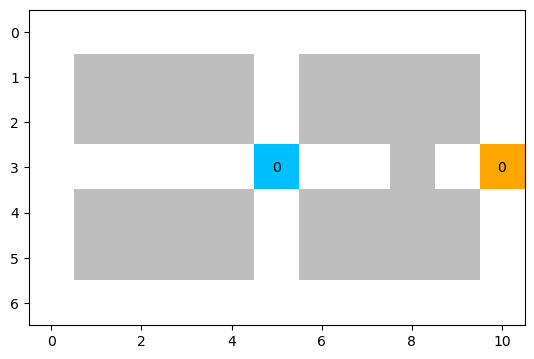

In [41]:
env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

### 방향 확인

Current position: [3 5]
New position after moving left: [2 5]


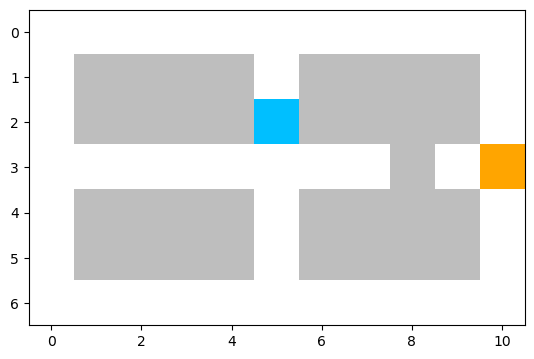

New position after moving right: [4 5]


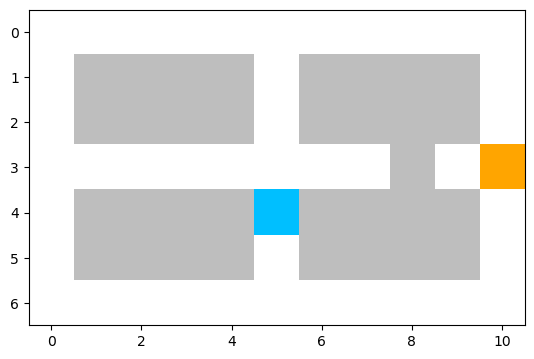

In [36]:
# 현재 에이전트의 위치 가져오기
current_position = env.agents_pos[0]
print("Current position:", current_position)

# 현재 위치
x, y = current_position

# 위(북쪽)으로 이동
new_position_left = (x-1, y)
env.agents_pos[0] = new_position_left
print("New position after moving left:", env.agents_pos[0])

# 환경 렌더링
env.render()

# 아래(남쪽)으로 이동
new_position_right = (x+1,y)
env.agents_pos[0] = new_position_right
print("New position after moving right:", env.agents_pos[0])

# 환경 렌더링
env.render()

## env.observe() 확인

In [11]:
env.observe()[0][0]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

<function matplotlib.pyplot.show(close=None, block=None)>

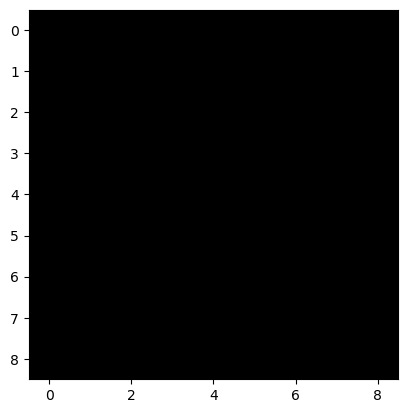

In [22]:
plt.imshow(env.observe()[0][0][0], cmap = 'gray', interpolation = 'none')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

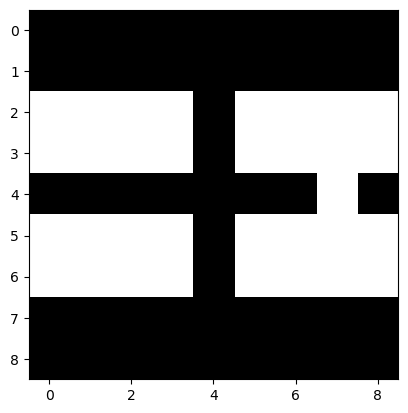

In [23]:
plt.imshow(env.observe()[0][0][1], cmap = 'gray', interpolation = 'none')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

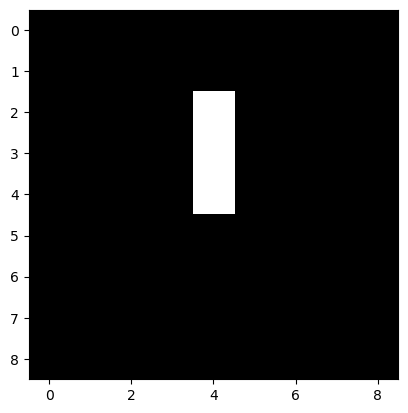

In [24]:
plt.imshow(env.observe()[0][0][2], cmap = 'gray', interpolation = 'none')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

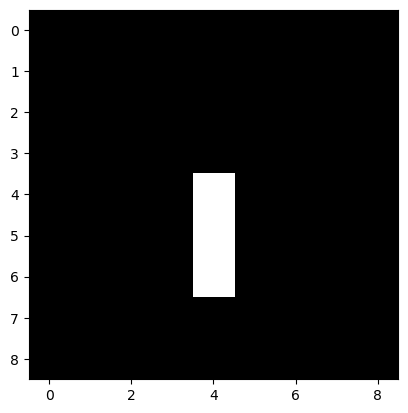

In [25]:
plt.imshow(env.observe()[0][0][3], cmap = 'gray', interpolation = 'none')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

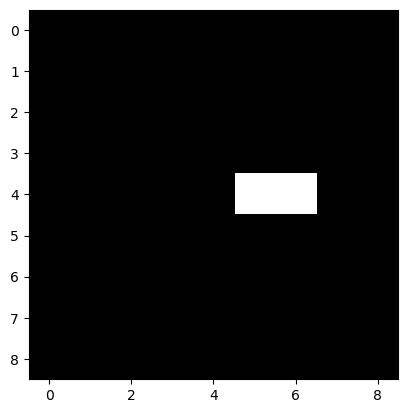

In [26]:
plt.imshow(env.observe()[0][0][4], cmap = 'gray', interpolation = 'none')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

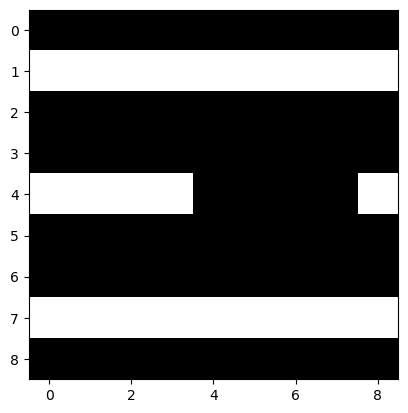

In [27]:
plt.imshow(env.observe()[0][0][5], cmap = 'gray', interpolation = 'none')
plt.show

## A* 알고리듬으로 길 찾기

In [65]:
import numpy as np

# 예시 9x9 매트릭스
observed_matrix = env.observe()[0][0][1]

# 첫 번째와 마지막 행 제거
trimmed_matrix = observed_matrix[1:-1, :]
print("After removing first and last rows:")
print(trimmed_matrix)

# 각 행의 처음과 끝에 0 추가
padded_matrix = np.pad(trimmed_matrix, ((0, 0), (1, 1)), mode='constant', constant_values=0)

print("After adding 0s to the start and end of each row:")
print(padded_matrix)

After removing first and last rows:
[[0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 0]
 [1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0]]
After adding 0s to the start and end of each row:
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


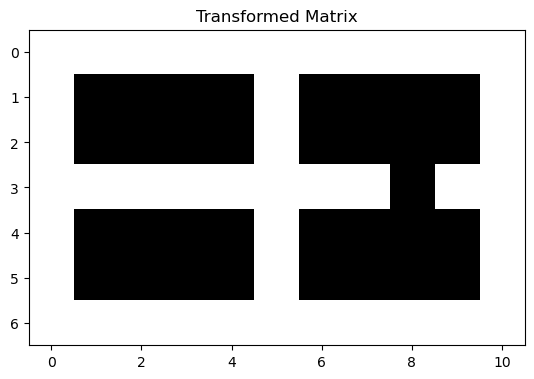

In [66]:
import matplotlib.pyplot as plt

# 변환된 매트릭스 시각화
plt.imshow(padded_matrix, cmap='gray_r', interpolation='none')
plt.title("Transformed Matrix")
plt.show()

In [67]:
# 장애물 정보 가져오기
obstacle_map = padded_matrix
print("Obstacle map:")
print(obstacle_map)

Obstacle map:
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 1 1 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [68]:
def heuristic(a, b):
    """맨해튼 거리를 계산하는 함수"""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(start, goal, obstacle_map):
    """A* 알고리즘을 사용하여 경로를 찾는 함수"""
    rows, cols = obstacle_map.shape
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # 동, 남, 서, 북 방향

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # 역순으로 반환

        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])

            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if obstacle_map[neighbor[0], neighbor[1]] == 1:
                    continue  # 장애물이라면 무시

                tentative_g_score = g_score[current] + 1

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None  # 경로를 찾지 못한 경우

# A* 알고리즘을 사용하여 경로 탐색
path = a_star_search(agent_start, agent_goal, obstacle_map)
print("Path found by A* algorithm:", path)

Path found by A* algorithm: [(3, 5), (2, 5), (1, 5), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 10), (2, 10), (3, 10)]


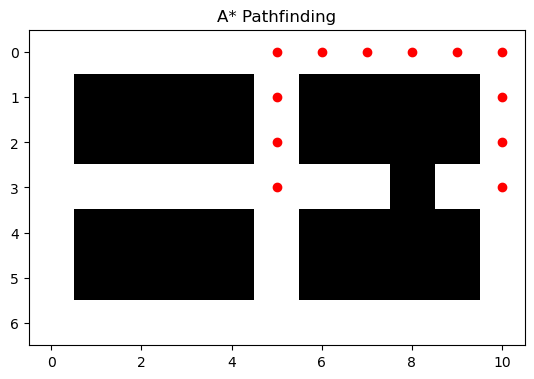

Path found successfully!


In [69]:
import matplotlib.pyplot as plt

def visualize_path(obstacle_map, path):
    """경로를 시각적으로 표현하는 함수"""
    plt.imshow(obstacle_map, cmap='gray_r', interpolation='none')

    if path:
        for position in path:
            plt.plot(position[1], position[0], 'ro')  # 경로를 빨간 점으로 표시

    plt.title("A* Pathfinding")
    plt.show()

# 경로 시각화
visualize_path(obstacle_map, path)

# 경로가 있는지 확인
if path:
    print("Path found successfully!")
else:
    print("No path found.")

## Agent, Task 정의하기

In [70]:
class PathFindingAgents:
    def path_finder(self, agent_number):
        return {
            'role': 'Path finder',
            'goal': 'Start at the start point and reach the end point without crashing into a wall.',
            'backstory': f"""You are a veteran adventurer with a great sense of direction.
            You understand which direction you need to move to get from where you are to where you want to go.
            Your agent number is {agent_number}.
            """,
            'verbose': True
        }


In [71]:
class PathFindingTasks:
    def __init__(self, env):
        self.env = env
        self.obstacle_map = padded_matrix
        
    def path_finding(self, agent, x, y, x_finish, y_finish, last_action):
        start = (x, y)
        goal = (x_finish, y_finish)
        path = a_star_search(start, goal, self.obstacle_map)

        return {
            'description': f"""
            Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
            Move according to the path found by A* algorithm.
            Current action: {last_action}
            Path: {path}
            """,
            'expected_output': 'Direction or Action',
            'agent': agent
        }

    def move_agent(self, agent_index, path):
        for position in path:
            self.env.agents_pos[agent_index] = position
            self.env.render()
            print(f"Agent {agent_index} moved to {position}")
            # Add delay or user input to see the step-by-step movement if needed

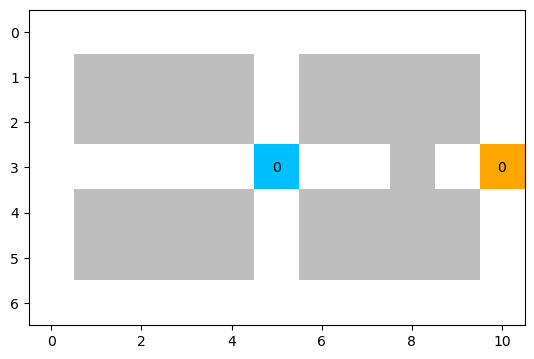


            Your current coordinates are (3,5) and your destination is (3,10).
            Move according to the path found by A* algorithm.
            Current action: None
            Path: [(3, 5), (2, 5), (1, 5), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 10), (2, 10), (3, 10)]
            
Path found for agent 0: [(3, 5), (2, 5), (1, 5), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 10), (2, 10), (3, 10)]


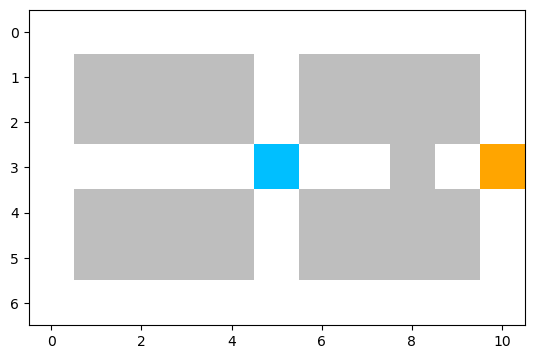

Agent 0 moved to (3, 5)


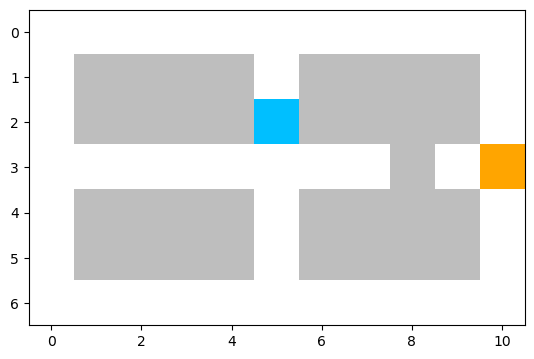

Agent 0 moved to (2, 5)


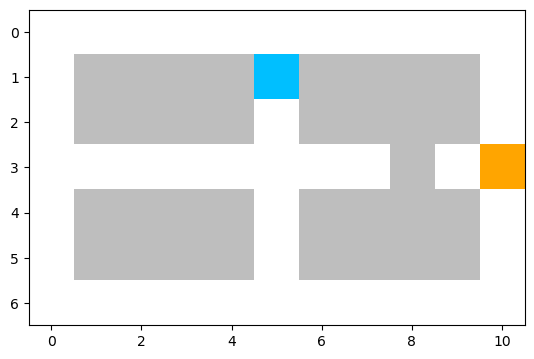

Agent 0 moved to (1, 5)


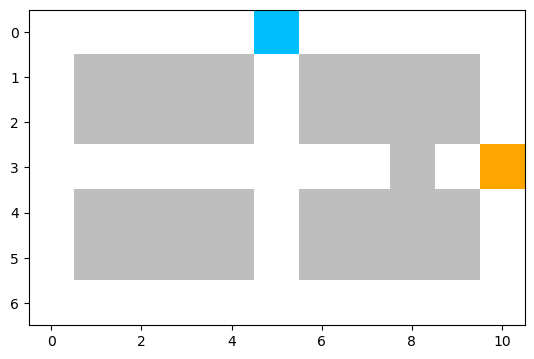

Agent 0 moved to (0, 5)


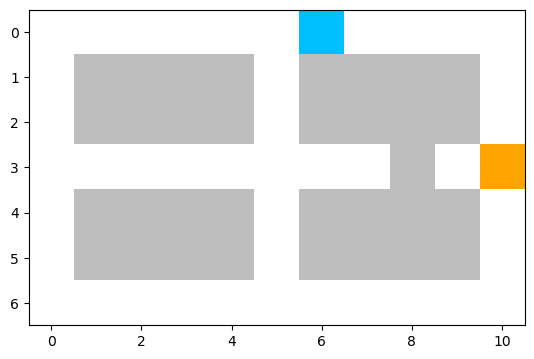

Agent 0 moved to (0, 6)


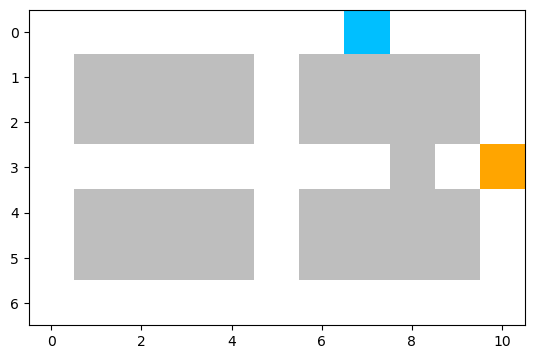

Agent 0 moved to (0, 7)


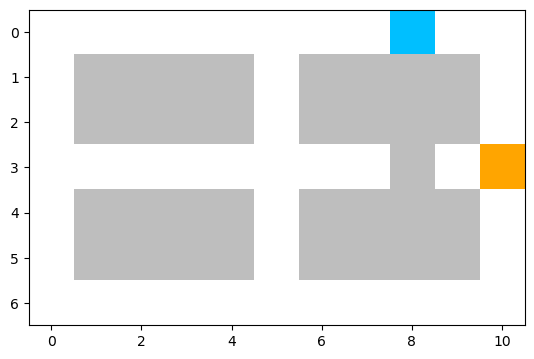

Agent 0 moved to (0, 8)


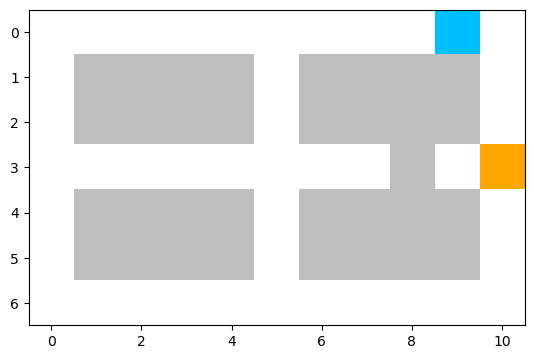

Agent 0 moved to (0, 9)


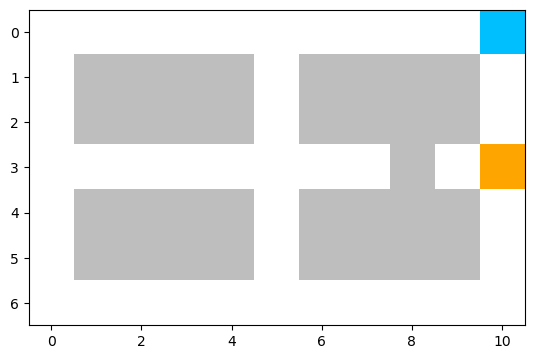

Agent 0 moved to (0, 10)


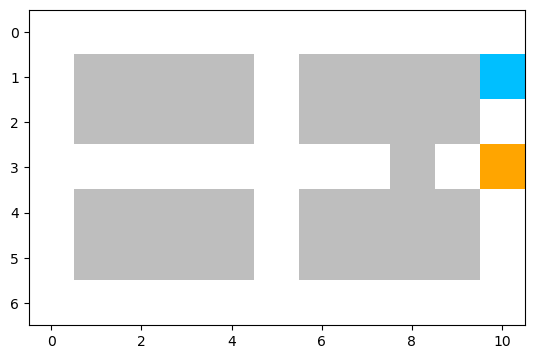

Agent 0 moved to (1, 10)


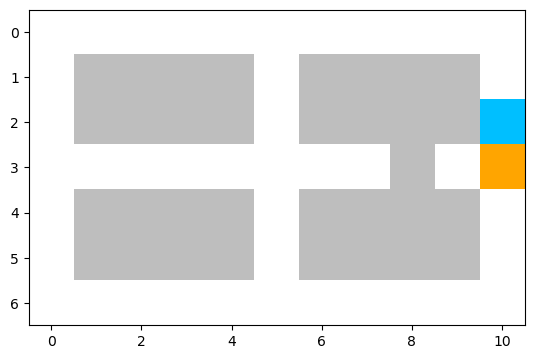

Agent 0 moved to (2, 10)


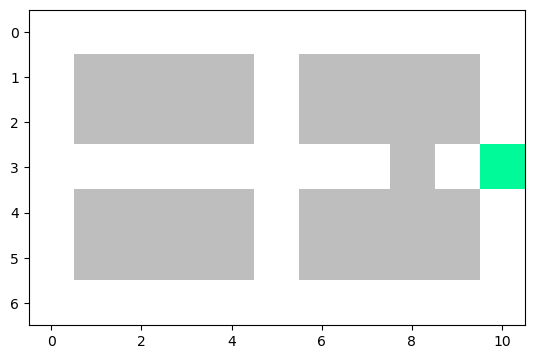

Agent 0 moved to (3, 10)


In [72]:
# 환경 초기화 및 설정
env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

# 에이전트 정의
agents = PathFindingAgents()
agents_set = [agents.path_finder(i) for i in range(num_agents)]

# 경로 탐색 작업 정의
tasks = PathFindingTasks(env)

# 모든 에이전트가 순차적으로 경로를 찾고 이동
for i in range(num_agents):
    agent_start = tuple(env.agents_pos[i])
    agent_goal = (toy[2][i][0], toy[2][i][1])

    task = tasks.path_finding(agents_set[i], agent_start[0], agent_start[1], agent_goal[0], agent_goal[1], 'None')
    print(task['description'])

    path = a_star_search(agent_start, agent_goal, toy[0])
    print(f"Path found for agent {i}: {path}")

    if path:
        tasks.move_agent(i, path)
    else:
        print(f"No path found for agent {i}.")